<a href="https://colab.research.google.com/github/Gangadari11/TileVizualiser/blob/main/imageseg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [116]:
!pip install torch torchvision transformers datasets accelerate evaluate
!pip install opencv-python pillow matplotlib

In [117]:
from transformers import Mask2FormerForUniversalSegmentation
from transformers import AutoImageProcessor
import torch

model_name = "facebook/mask2former-swin-base-ade-semantic"

processor = AutoImageProcessor.from_pretrained(model_name)
model = Mask2FormerForUniversalSegmentation.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()


Loading weights:   0%|          | 0/782 [00:00<?, ?it/s]

Mask2FormerForUniversalSegmentation(
  (model): Mask2FormerModel(
    (pixel_level_module): Mask2FormerPixelLevelModule(
      (encoder): SwinBackbone(
        (embeddings): SwinEmbeddings(
          (patch_embeddings): SwinPatchEmbeddings(
            (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
          )
          (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): SwinEncoder(
          (layers): ModuleList(
            (0): SwinStage(
              (blocks): ModuleList(
                (0): SwinLayer(
                  (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
                  (attention): SwinAttention(
                    (self): SwinSelfAttention(
                      (query): Linear(in_features=128, out_features=128, bias=True)
                      (key): Linear(in_features=128, out_features=128, bias=True)
                      (valu

In [118]:
from google.colab import files
print("Upload ROOM image:")
uploaded = files.upload()


Upload ROOM image:


Saving room2.webp to room2 (1).webp


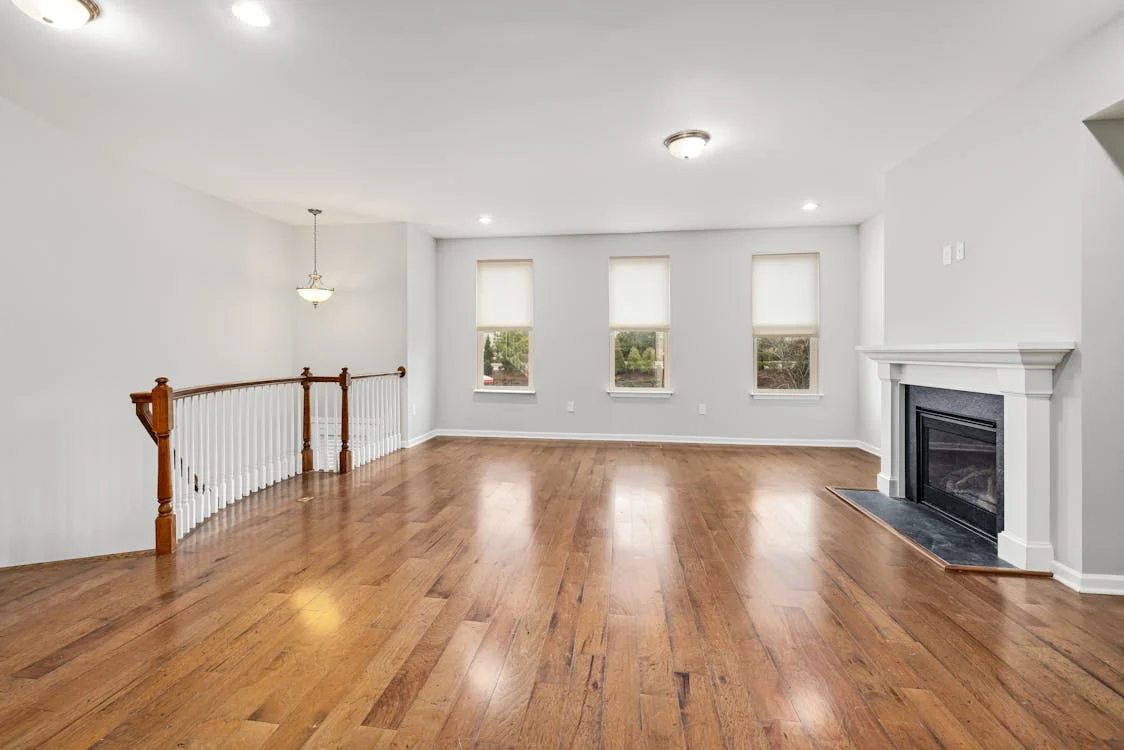

In [119]:
from PIL import Image
import numpy as np

image = Image.open(list(uploaded.keys())[0]).convert("RGB")
image


In [120]:
inputs = processor(images=image, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)

result = processor.post_process_semantic_segmentation(
    outputs,
    target_sizes=[image.size[::-1]]
)[0]

segmentation_map = result.cpu().numpy()


In [121]:
model.config.id2label


{0: 'wall',
 1: 'building',
 2: 'sky',
 3: 'floor',
 4: 'tree',
 5: 'ceiling',
 6: 'road',
 7: 'bed ',
 8: 'windowpane',
 9: 'grass',
 10: 'cabinet',
 11: 'sidewalk',
 12: 'person',
 13: 'earth',
 14: 'door',
 15: 'table',
 16: 'mountain',
 17: 'plant',
 18: 'curtain',
 19: 'chair',
 20: 'car',
 21: 'water',
 22: 'painting',
 23: 'sofa',
 24: 'shelf',
 25: 'house',
 26: 'sea',
 27: 'mirror',
 28: 'rug',
 29: 'field',
 30: 'armchair',
 31: 'seat',
 32: 'fence',
 33: 'desk',
 34: 'rock',
 35: 'wardrobe',
 36: 'lamp',
 37: 'bathtub',
 38: 'railing',
 39: 'cushion',
 40: 'base',
 41: 'box',
 42: 'column',
 43: 'signboard',
 44: 'chest of drawers',
 45: 'counter',
 46: 'sand',
 47: 'sink',
 48: 'skyscraper',
 49: 'fireplace',
 50: 'refrigerator',
 51: 'grandstand',
 52: 'path',
 53: 'stairs',
 54: 'runway',
 55: 'case',
 56: 'pool table',
 57: 'pillow',
 58: 'screen door',
 59: 'stairway',
 60: 'river',
 61: 'bridge',
 62: 'bookcase',
 63: 'blind',
 64: 'coffee table',
 65: 'toilet',
 66: '

In [122]:
WALL_ID = 0
FLOOR_ID = 3

wall_mask = (segmentation_map == WALL_ID).astype(np.uint8) * 255
floor_mask = (segmentation_map == FLOOR_ID).astype(np.uint8) * 255


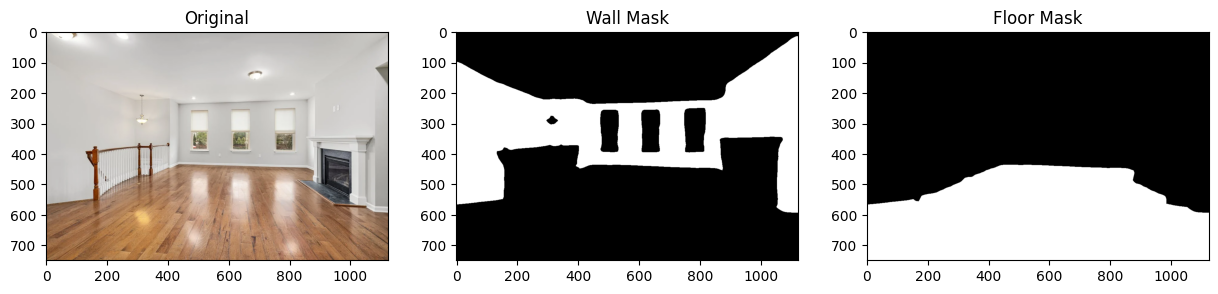

In [123]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(image)
plt.title("Original")

plt.subplot(1,3,2)
plt.imshow(wall_mask, cmap="gray")
plt.title("Wall Mask")

plt.subplot(1,3,3)
plt.imshow(floor_mask, cmap="gray")
plt.title("Floor Mask")

plt.show()


In [124]:
from google.colab import files
print("Upload Tile image:")
uploaded_tile = files.upload()


Upload Tile image:


Saving tile3.jpg to tile3 (2).jpg


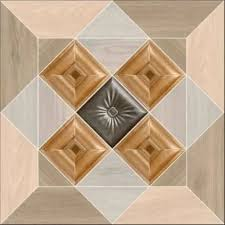

In [125]:
tile_img = Image.open(list(uploaded_tile.keys())[0]).convert("RGB")
tile_img


In [126]:
import numpy as np

tile_np = np.array(tile_img)
room_h, room_w = image.size[1], image.size[0]

tile_h, tile_w = tile_np.shape[:2]

repeat_y = room_h // tile_h + 1
repeat_x = room_w // tile_w + 1

big_tile = np.tile(tile_np, (repeat_y, repeat_x, 1))
big_tile = big_tile[:room_h, :room_w]


In [127]:
room_np = np.array(image)

floor_mask_bool = floor_mask.astype(bool)

result_img = room_np.copy()
result_img[floor_mask_bool] = big_tile[floor_mask_bool]


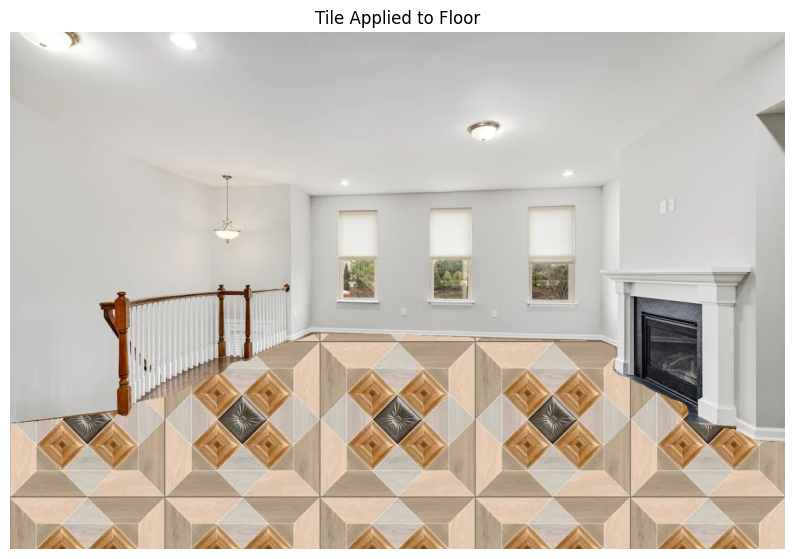

In [128]:
plt.figure(figsize=(10,8))
plt.imshow(result_img)
plt.axis("off")
plt.title("Tile Applied to Floor")
plt.show()


# Realistic Editition

In [129]:
import cv2
import numpy as np

def create_tile_pattern(width, height, tile_img, tile_size=120, grout=3):

    grout_color = 220
    pattern = np.ones((height, width, 3), dtype=np.uint8) * grout_color

    tile_resized = cv2.resize(tile_img, (tile_size-grout, tile_size-grout))

    for y in range(0, height, tile_size):
        for x in range(0, width, tile_size):

            variation = 0.95 + 0.1*np.random.rand()
            tile_var = np.clip(tile_resized * variation, 0, 255).astype(np.uint8)

            y_end = min(y+tile_size-grout, height)
            x_end = min(x+tile_size-grout, width)

            pattern[y:y_end, x:x_end] = tile_var[:y_end-y, :x_end-x]

    return pattern



In [130]:
def order_points_clockwise(pts):

    rect = np.zeros((4,2), dtype="float32")

    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]  # top-left
    rect[2] = pts[np.argmax(s)]  # bottom-right

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # top-right
    rect[3] = pts[np.argmax(diff)]  # bottom-left

    return rect


In [131]:
def get_floor_corners(mask):

    mask = (mask > 0).astype(np.uint8)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(contours, key=cv2.contourArea)

    # Convex hull (important!)
    hull = cv2.convexHull(cnt)

    epsilon = 0.02 * cv2.arcLength(hull, True)
    approx = cv2.approxPolyDP(hull, epsilon, True)

    if len(approx) < 4:
        return None

    pts = approx.reshape(-1, 2)

    # If more than 4 points, take extreme 4 via bounding quad
    if len(pts) > 4:
        rect = cv2.minAreaRect(hull)
        pts = cv2.boxPoints(rect)

    pts = order_points_clockwise(pts)

    return np.float32(pts)


In [132]:
def extract_lighting(original_img):
    gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    gray_blur = cv2.GaussianBlur(gray, (51,51), 0)
    lighting = gray_blur / 255.0
    return lighting


In [133]:
import numpy as np
import cv2

# Convert PIL to OpenCV format
image = np.array(image)

# Convert RGB (PIL) → BGR (OpenCV)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

# Convert PIL Image to numpy array (RGB)
tile_img_np = np.array(tile_img)
# Convert RGB (numpy) to BGR (OpenCV)
tile_img_cv = cv2.cvtColor(tile_img_np, cv2.COLOR_RGB2BGR)


In [134]:
def apply_realistic_tile(original_img, mask, tile_img, rotation_angle=0):

    H, W = original_img.shape[:2]
    mask = (mask > 0).astype(np.uint8) * 255

    # Get floor corners
    dst_pts = get_floor_corners(mask)

    if dst_pts is None:
      print("Could not detect proper floor corners")
      return original_img

    # 1. Define original desired tile plane dimensions
    original_flat_w = 1200
    original_flat_h = 1200

    # 2. Calculate expanded dimension based on diagonal
    expanded_dim = int(np.ceil(np.sqrt(original_flat_w**2 + original_flat_h**2)))

    # 3. Create flat tile pattern with expanded dimensions
    tile_pattern = create_tile_pattern(expanded_dim, expanded_dim, tile_img)

    # 4. Calculate offsets to center the original area within the expanded pattern
    offset_x = (expanded_dim - original_flat_w) / 2
    offset_y = (expanded_dim - original_flat_h) / 2

    # 5. Redefine src_pts to represent the corners of the original desired tile area,
    #    centered within the larger tile_pattern
    src_pts = np.float32([
        [offset_x, offset_y],
        [offset_x + original_flat_w, offset_y],
        [offset_x + original_flat_w, offset_y + original_flat_h],
        [offset_x, offset_y + original_flat_h]
    ])

    # 6. Calculate the center of src_pts for rotation within the expanded space
    center_x = np.mean(src_pts[:, 0])
    center_y = np.mean(src_pts[:, 1])
    center = (center_x, center_y)

    # Create rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)

    # Apply rotation to src_pts
    # cv2.transform expects points in shape (N, 1, 2)
    rotated_src_pts = cv2.transform(src_pts.reshape(-1, 1, 2), rotation_matrix).reshape(-1, 2)

    # Compute homography with rotated src_pts
    H_matrix = cv2.getPerspectiveTransform(rotated_src_pts, dst_pts)

    warped_tiles = cv2.warpPerspective(tile_pattern, H_matrix, (W,H))

    # ---- BETTER LIGHTING (Fix dark issue) ----
    gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    lighting = cv2.GaussianBlur(gray, (31,31), 0) / 255.0

    # Reduce lighting influence so it doesn't darken too much
    lighting = 0.6 + 0.4 * lighting

    realistic_tiles = warped_tiles.astype(np.float32) * lighting[:,:,None]
    realistic_tiles = np.clip(realistic_tiles, 0, 255).astype(np.uint8)

    # ---- Blend ----
    mask_blur = cv2.GaussianBlur(mask, (21,21), 0)
    mask_norm = mask_blur / 255.0
    mask_3 = np.stack([mask_norm]*3, axis=-1)

    result = original_img * (1-mask_3) + realistic_tiles * mask_3
    result = result.astype(np.uint8)

    return result

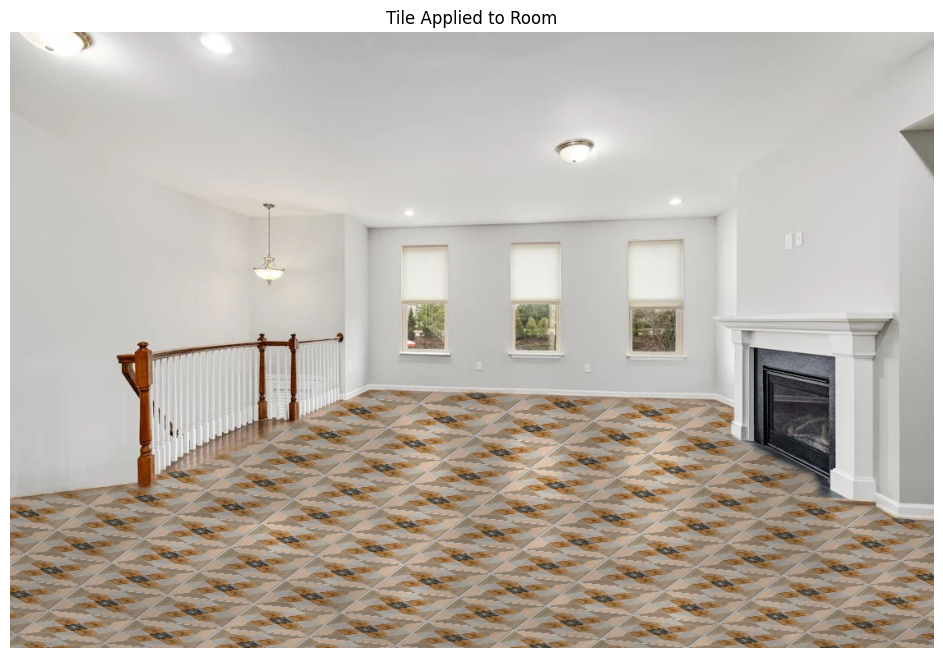

In [136]:
result_rotated = apply_realistic_tile(image, floor_mask, tile_img_cv, rotation_angle=20)

plt.figure(figsize=(12,8))
plt.imshow(cv2.cvtColor(result_rotated, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Tile Applied to Room")
plt.show()

## Summary:

### Data Analysis Key Findings
*   The issue of black spaces appearing in the corners when rotating a tile pattern was resolved by dynamically expanding the size of the `tile_pattern`.
*   The `original_flat_w` and `original_flat_h` for the desired tile area were set to 1200x1200 pixels.
*   An `expanded_dim` for the tile pattern was calculated based on the diagonal length of these original dimensions, specifically using the formula `int(np.ceil(np.sqrt(original_flat_w**2 + original_flat_h**2)))`, which results in an expanded dimension of approximately 1698 pixels.
*   The `tile_pattern` was then created with these expanded dimensions, ensuring it was large enough to contain any rotation of the original 1200x1200 area.
*   Source points (`src_pts`) were redefined to represent the corners of the original desired 1200x1200 tile area, precisely centered within the larger `tile_pattern` using calculated `offset_x` and `offset_y` values.
*   The rotation center was also adjusted to be the mean of these new, centered `src_pts`, guaranteeing that the rotation occurs correctly within the expanded space.
*   The modified function was successfully applied with a rotation angle of -50 degrees, and the visualization confirmed the elimination of black spaces, indicating a successful resolution of the problem.

### Insights or Next Steps
*   The dynamic expansion of the tile pattern based on the diagonal and precise centering of the source points effectively eliminates visual artifacts (black spaces) that arise from rotation, significantly improving the robustness of the tile application process.
*   Future improvements could involve generalizing the `original_flat_w` and `original_flat_h` parameters to be dynamically derived from the floor mask or user input, offering more flexibility for different floor sizes.
